# SAMPIC Waveform Visualization

Comprehensive notebook for analyzing SAMPIC waveforms using PyROOT.

In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import os

# Set up plotting defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# Paths
DATA_FILE = "../../output.root"
BUILD_LIB_PATH = "../../build/lib"

## Load Libraries and Data

In [2]:
# Load SAMPIC data product libraries
libs_to_load = [
    "libanalysis_pipeline_core.so",
    "libunpacker_data_products_core.so",
    "libunpacker_data_products_sampic.so",
]

for lib in libs_to_load:
    path = os.path.join(BUILD_LIB_PATH, lib)
    if os.path.exists(path):
        print(f"Loading {lib}...")
        ROOT.gSystem.Load(path)
    else:
        print(f"Warning: {lib} not found")

Loading libanalysis_pipeline_core.so...
Loading libunpacker_data_products_core.so...
Loading libunpacker_data_products_sampic.so...


In [3]:
# Open file and get tree
f = ROOT.TFile.Open(DATA_FILE)
if not f or f.IsZombie():
    print(f"Error: Could not open file {DATA_FILE}")
else:
    tree = f.Get("events")
    print(f"Loaded tree with {tree.GetEntries()} entries")
    print()  # Blank line before listing branches
    print("Available branches:")
    for branch in tree.GetListOfBranches():
        print(f"  - {branch.GetName()}")
    if tree.GetBranch("has_sampic_collector_timing"):
        print()  # Separate explanatory note
        print("Branch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.")


Loaded tree with 85135 entries

Available branches:
  - sampic_event
  - sampic_event_timing
  - sampic_collector_timing
  - has_sampic_collector_timing

Branch 'has_sampic_collector_timing' indicates whether the AC00 bank was present for each event.


## Explore Data Structure

In [11]:
tree.GetEntry(0)
event = tree.sampic_event

print(f"Number of hits in first event: {len(event.hits)}")

for i, hit in enumerate(event.hits):
    print(f"\n=== Hit {i} ===")
    print(f"fe_board_index            : {hit.fe_board_index}")
    print(f"channel                   : {hit.channel}")
    print(f"hit_number                : {hit.hit_number}")
    print(f"sampic_index              : {hit.sampic_index}")
    print(f"channel_index             : {hit.channel_index}")

    print(f"inl_corrected             : {hit.inl_corrected}")
    print(f"adc_corrected             : {hit.adc_corrected}")
    print(f"residual_pedestal_corrected: {hit.residual_pedestal_corrected}")

    print(f"cell_info                 : {hit.cell_info}")
    print(f"first_cell_physical_index : {hit.first_cell_physical_index}")

    print(f"corrected_waveform length : {len(hit.corrected_waveform)}")
    if len(hit.corrected_waveform) > 0:
        print(f"  first 5 samples         : {hit.corrected_waveform[:5]}")

    print(f"raw_tot_value             : {hit.raw_tot_value}")
    print(f"tot_value                 : {hit.tot_value}")
    print(f"amplitude                 : {hit.amplitude}")
    print(f"baseline                  : {hit.baseline}")
    print(f"peak                      : {hit.peak}")
    print(f"time_index                : {hit.time_index}")
    print(f"time_instant              : {hit.time_instant}")
    print(f"time_amplitude            : {hit.time_amplitude}")
    print(f"first_cell_timestamp      : {hit.first_cell_timestamp}")


Number of hits in first event: 1

=== Hit 0 ===
fe_board_index            : 0
channel                   : 29
hit_number                : 0
sampic_index              : 1
channel_index             : 13
inl_corrected             : False
adc_corrected             : False
residual_pedestal_corrected: False
cell_info                 : 0
first_cell_physical_index : 5
corrected_waveform length : 64
  first 5 samples         : { 1183.00f, 1177.00f, 1202.00f, 1199.00f, 1183.00f }
raw_tot_value             : 0
tot_value                 : 0.0
amplitude                 : -1.0
baseline                  : -1.0
peak                      : -1.0
time_index                : -1.0
time_instant              : -1.0
time_amplitude            : -1.0
first_cell_timestamp      : 2238730.78125


## Individual Waveform Plots

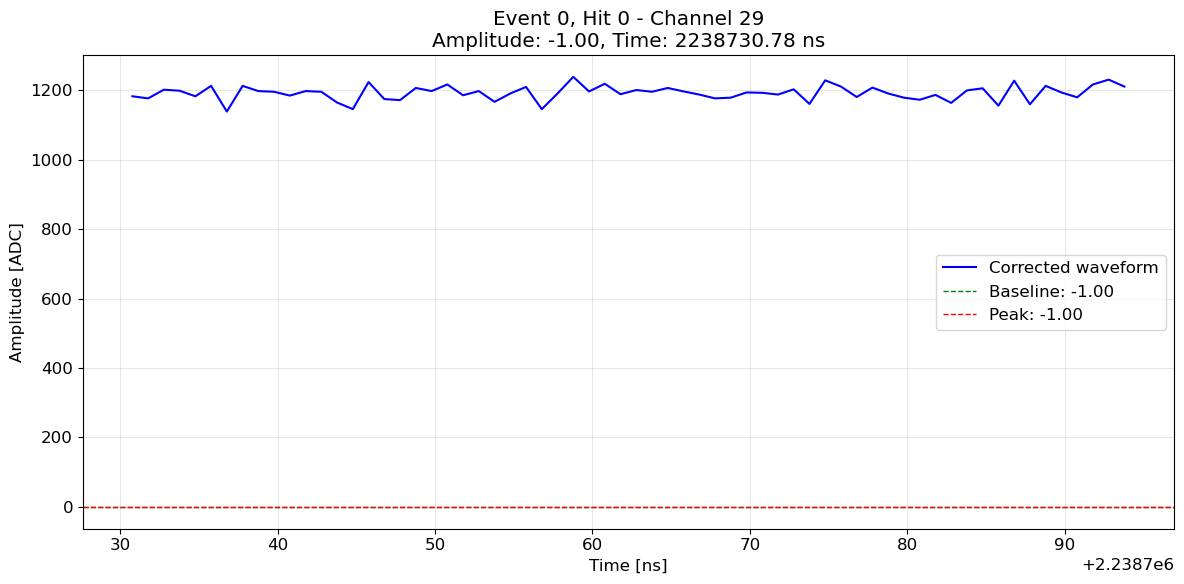

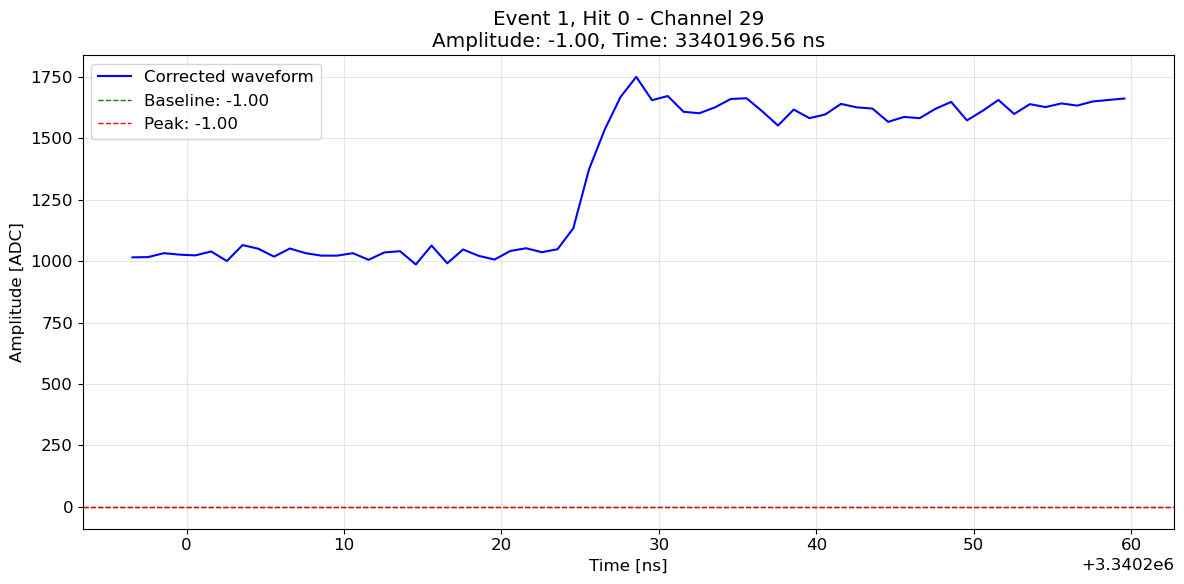

In [12]:
def plot_waveform(event_idx, hit_idx):
    """Plot a single waveform from a specific event and hit using first cell timestamp as ns reference."""
    tree.GetEntry(event_idx)
    event = tree.sampic_event
    
    if hit_idx >= len(event.hits):
        print(f"Hit {hit_idx} out of range")
        return
    
    hit = event.hits[hit_idx]
    wf = hit.corrected_waveform
    waveform = np.array([wf[i] for i in range(len(wf))], dtype=np.float32)
    
    # x-axis in ns, offset by first cell timestamp
    sample_indices = np.arange(len(waveform))
    time_ns = hit.first_cell_timestamp + sample_indices  # assuming 1 sample ≈ 1 ns
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    ax.plot(time_ns, waveform, 'b-', linewidth=1.5, label='Corrected waveform')
    
    ax.axhline(y=hit.baseline, color='g', linestyle='--', linewidth=1, label=f'Baseline: {hit.baseline:.2f}')
    ax.axhline(y=hit.peak, color='r', linestyle='--', linewidth=1, label=f'Peak: {hit.peak:.2f}')
    
    ax.set_xlabel('Time [ns]')
    ax.set_ylabel('Amplitude [ADC]')
    ax.set_title(f'Event {event_idx}, Hit {hit_idx} - Channel {hit.channel}\n'
                 f'Amplitude: {hit.amplitude:.2f}, Time: {hit.first_cell_timestamp:.2f} ns')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig


# Example usage:
tree.GetEntry(0)
if len(tree.sampic_event.hits) > 0:
    plot_waveform(0, 0)
    plt.show()


# Plot first waveform from second event
tree.GetEntry(1)
if len(tree.sampic_event.hits) > 0:
    plot_waveform(1, 0)
    plt.show()

## Multi-Hit Event Visualization

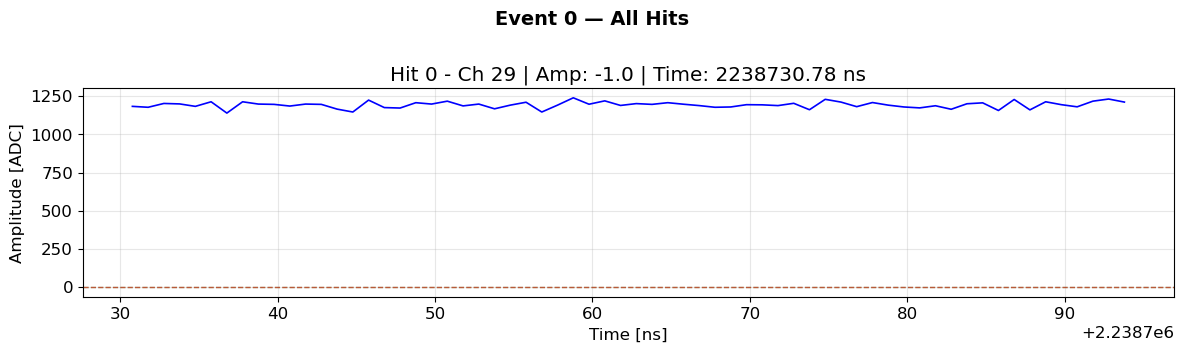

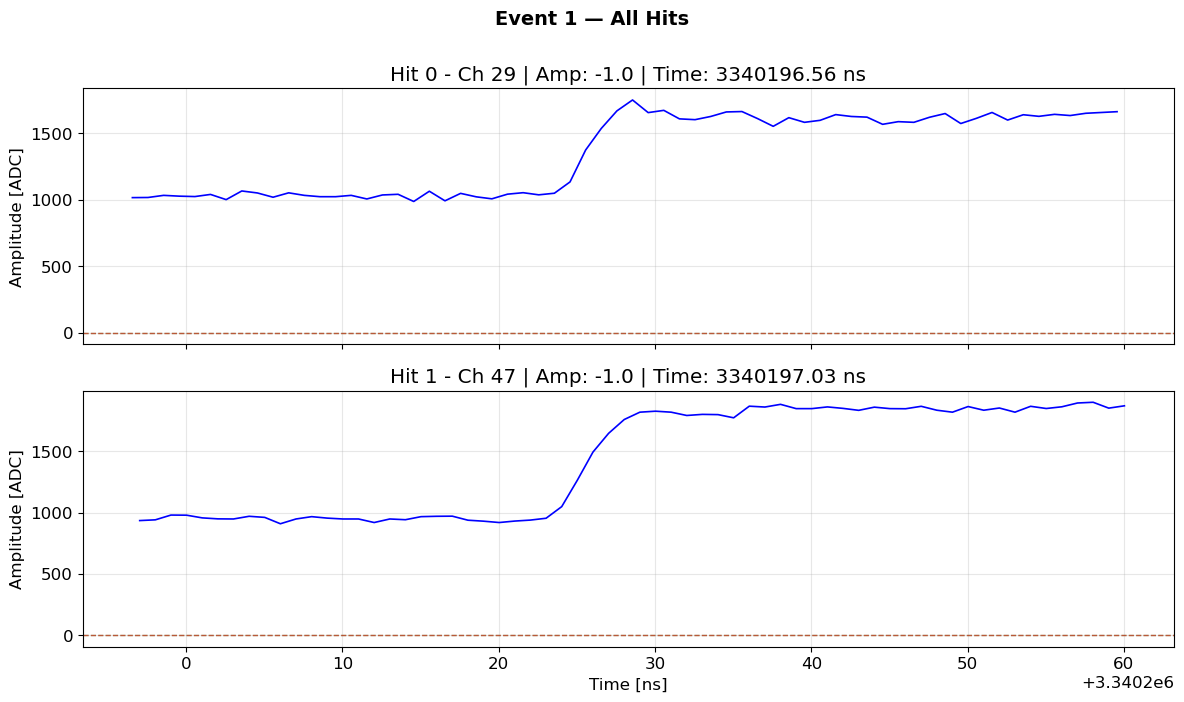

In [13]:
def plot_event_waveforms(event_idx, max_hits=400, sample_period_ns=1.0):
    """Plot multiple waveforms from a single event, using first cell timestamp as the ns reference."""
    tree.GetEntry(event_idx)
    event = tree.sampic_event
    num_hits = min(len(event.hits), max_hits)
    
    if num_hits == 0:
        print(f"Event {event_idx} has no hits")
        return None
    
    fig, axes = plt.subplots(num_hits, 1, figsize=(12, 3.5*num_hits), sharex=True)
    if num_hits == 1:
        axes = [axes]
    
    for i in range(num_hits):
        hit = event.hits[i]
        wf = hit.corrected_waveform
        if not wf:
            continue
        
        waveform = np.array(wf, dtype=np.float32)
        sample_indices = np.arange(len(waveform))
        time_ns = hit.first_cell_timestamp + sample_indices * sample_period_ns
        
        axes[i].plot(time_ns, waveform, 'b-', linewidth=1.2)
        axes[i].axhline(y=hit.baseline, color='g', linestyle='--', linewidth=1, alpha=0.5)
        axes[i].axhline(y=hit.peak, color='r', linestyle='--', linewidth=1, alpha=0.5)
        
        axes[i].set_ylabel('Amplitude [ADC]')
        axes[i].set_title(
            f'Hit {i} - Ch {hit.channel} | Amp: {hit.amplitude:.1f} | '
            f'Time: {hit.first_cell_timestamp:.2f} ns'
        )
        axes[i].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time [ns]')
    fig.suptitle(f'Event {event_idx} — All Hits', fontsize=14, fontweight='bold', y=1.001)
    plt.tight_layout()
    
    return fig


# Plot first event with multiple hits
plot_event_waveforms(0, max_hits=40)
plt.show()

# Plot second event with multiple hits
plot_event_waveforms(1, max_hits=40)
plt.show()

## Statistical Analysis

In [15]:
# Collect data from many events
n_events = min(100000, tree.GetEntries())

amplitudes = []
baselines = []
peaks = []
channels = []
tot_values = []
time_instants = []
first_cell_timestamps = []
num_hits_per_event = []

for i in range(n_events):
    tree.GetEntry(i)
    event = tree.sampic_event

    # store multiplicity once per event
    num_hits_per_event.append(len(event.hits))

    for hit in event.hits:
        amplitudes.append(hit.amplitude)
        baselines.append(hit.baseline)
        peaks.append(hit.peak)
        channels.append(hit.channel)
        tot_values.append(hit.tot_value)
        time_instants.append(hit.time_instant)

        # NEW
        first_cell_timestamps.append(hit.first_cell_timestamp)

# Convert to numpy arrays
amplitudes = np.array(amplitudes)
baselines = np.array(baselines)
peaks = np.array(peaks)
channels = np.array(channels)
tot_values = np.array(tot_values)
time_instants = np.array(time_instants)
first_cell_timestamps = np.array(first_cell_timestamps)
num_hits_per_event = np.array(num_hits_per_event)

print(f"Total hits analyzed: {len(amplitudes)}")
print("\nAmplitude statistics:")
print(f"  Mean: {np.mean(amplitudes):.2f}")
print(f"  Std:  {np.std(amplitudes):.2f}")
print(f"  Min:  {np.min(amplitudes):.2f}")
print(f"  Max:  {np.max(amplitudes):.2f}")


Total hits analyzed: 467871

Amplitude statistics:
  Mean: -1.00
  Std:  0.00
  Min:  -1.00
  Max:  -1.00


## Distribution Plots

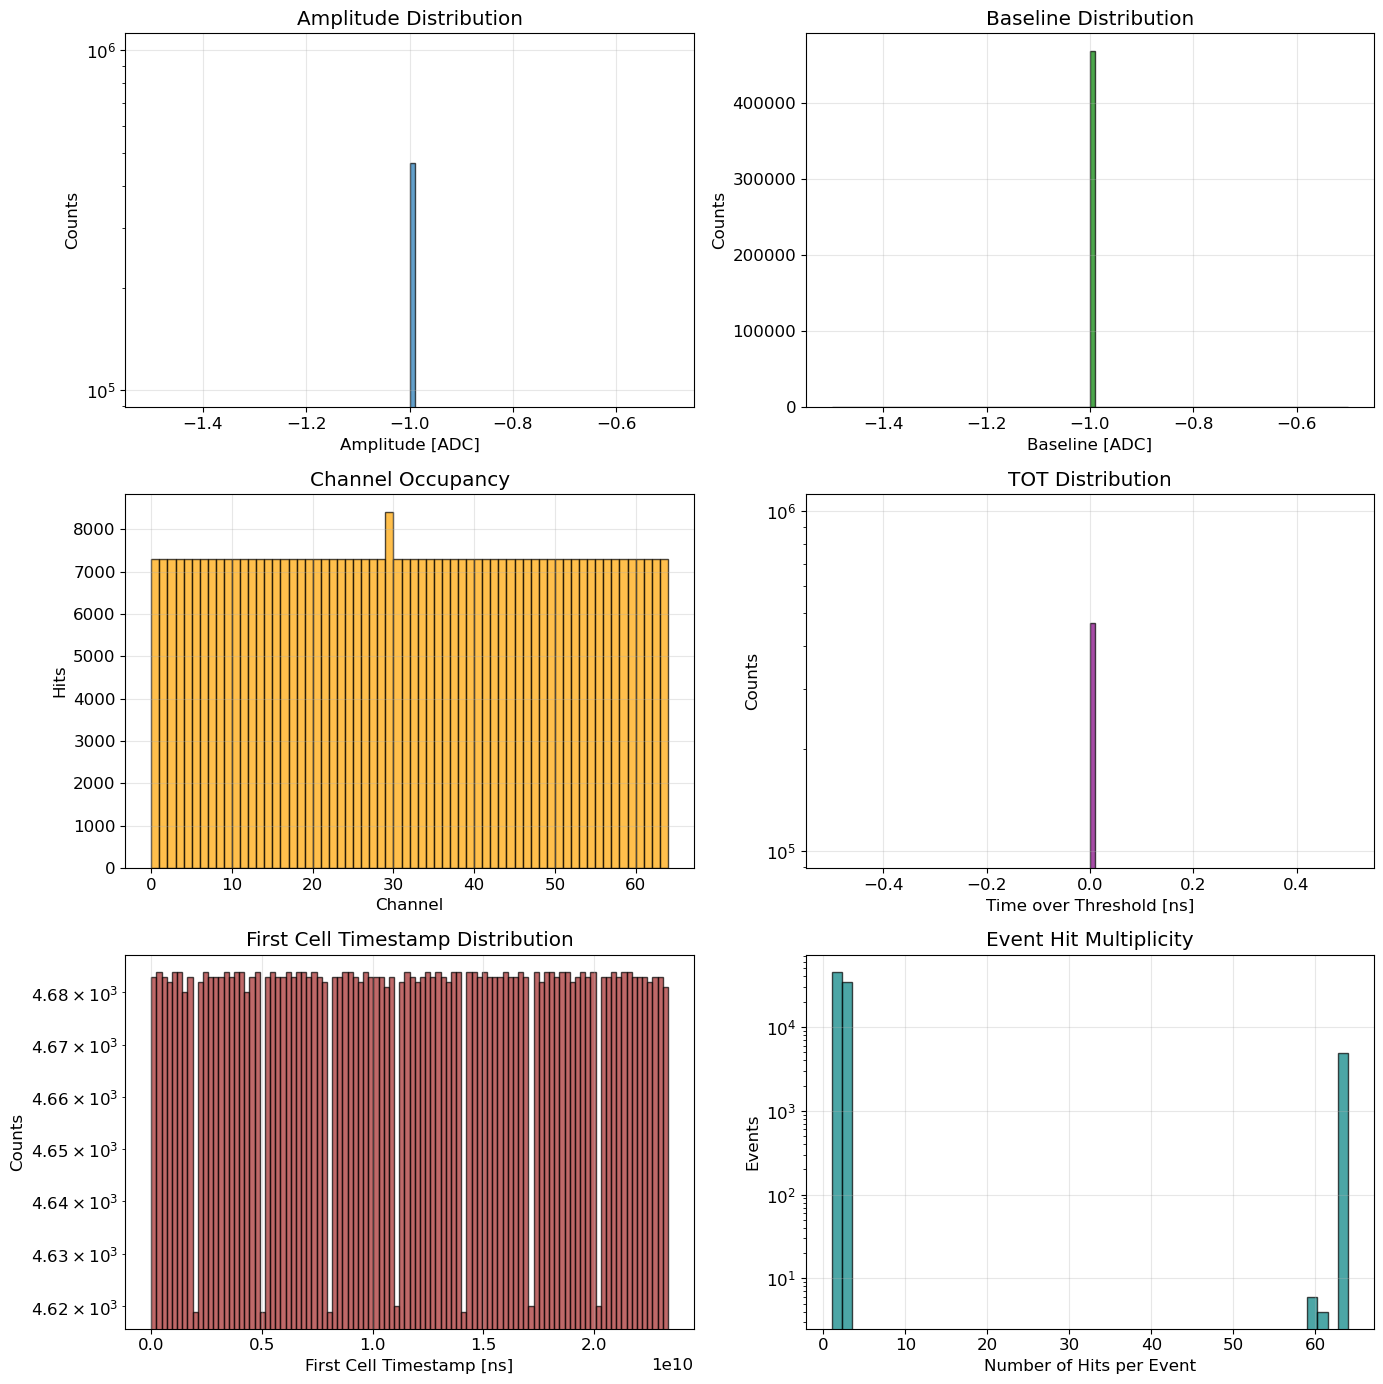

In [16]:
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

# --- Amplitude distribution ---
axes[0, 0].hist(amplitudes, bins=100, alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Amplitude [ADC]')
axes[0, 0].set_ylabel('Counts')
axes[0, 0].set_title('Amplitude Distribution')
axes[0, 0].set_yscale('log')

# --- Baseline distribution ---
axes[0, 1].hist(baselines, bins=100, alpha=0.7, edgecolor='black', color='green')
axes[0, 1].set_xlabel('Baseline [ADC]')
axes[0, 1].set_ylabel('Counts')
axes[0, 1].set_title('Baseline Distribution')

# --- Channel occupancy ---
axes[1, 0].hist(channels, bins=64, range=(0, 64), alpha=0.7, edgecolor='black', color='orange')
axes[1, 0].set_xlabel('Channel')
axes[1, 0].set_ylabel('Hits')
axes[1, 0].set_title('Channel Occupancy')

# --- TOT distribution ---
axes[1, 1].hist(tot_values, bins=100, alpha=0.7, edgecolor='black', color='purple')
axes[1, 1].set_xlabel('Time over Threshold [ns]')
axes[1, 1].set_ylabel('Counts')
axes[1, 1].set_title('TOT Distribution')
axes[1, 1].set_yscale('log')

# --- First cell timestamp distribution ---
axes[2, 0].hist(first_cell_timestamps, bins=100, alpha=0.7, edgecolor='black', color='brown')
axes[2, 0].set_xlabel('First Cell Timestamp [ns]')
axes[2, 0].set_ylabel('Counts')
axes[2, 0].set_title('First Cell Timestamp Distribution')
axes[2, 0].set_yscale('log')

# --- Number of hits per event distribution ---
axes[2, 1].hist(num_hits_per_event, bins=50, alpha=0.7, edgecolor='black', color='teal')
axes[2, 1].set_xlabel('Number of Hits per Event')
axes[2, 1].set_ylabel('Events')
axes[2, 1].set_title('Event Hit Multiplicity')
axes[2, 1].set_yscale('log')

plt.tight_layout()
plt.show()


## Peak vs Amplitude Correlation

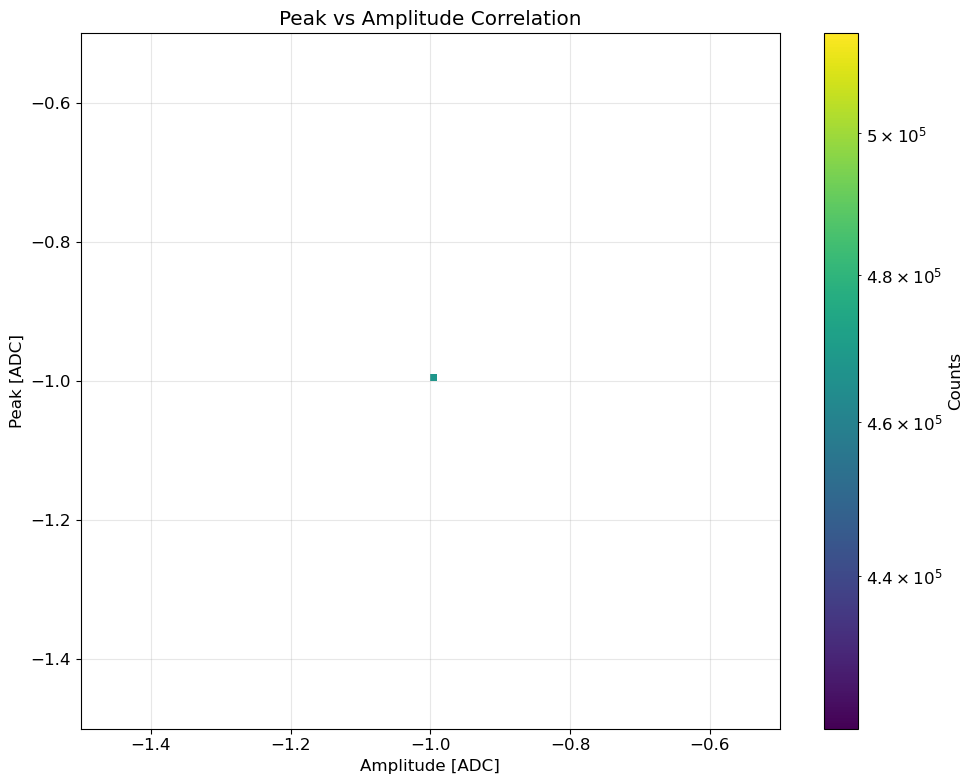

In [9]:
fig, ax = plt.subplots(figsize=(10, 8))

# Create 2D histogram
h = ax.hist2d(amplitudes, peaks, bins=100, cmap='viridis', 
              cmin=1, norm=plt.matplotlib.colors.LogNorm())
plt.colorbar(h[3], ax=ax, label='Counts')

ax.set_xlabel('Amplitude [ADC]')
ax.set_ylabel('Peak [ADC]')
ax.set_title('Peak vs Amplitude Correlation')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Average Waveform Shape

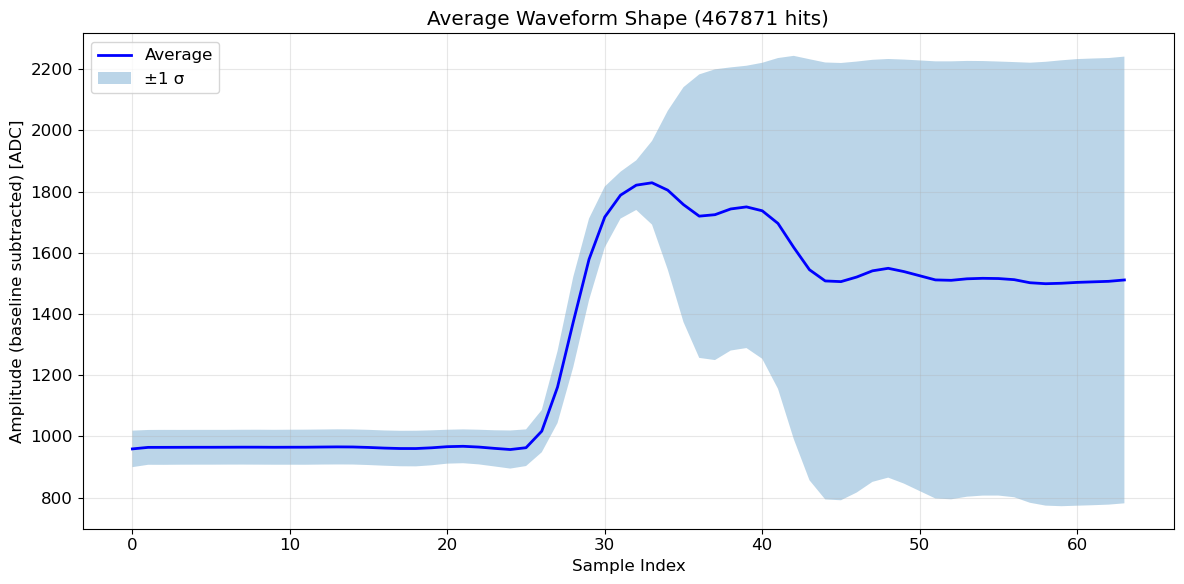

Analyzed 467871 waveforms
Maximum waveform length: 64 samples


In [10]:
# Collect waveforms from first N events
n_events_wf = min(100000, tree.GetEntries())
all_waveforms = []

for i in range(n_events_wf):
    tree.GetEntry(i)
    event = tree.sampic_event
    for hit in event.hits:
        wf = hit.corrected_waveform
        if len(wf) > 0:
            wf_array = np.array([wf[j] for j in range(len(wf))], dtype=np.float32)
            # Subtract baseline
            all_waveforms.append(wf_array - hit.baseline)

if len(all_waveforms) > 0:
    # Find maximum length
    max_len = max(len(wf) for wf in all_waveforms)
    
    # Pad shorter waveforms with zeros
    padded_waveforms = np.array([np.pad(wf, (0, max_len - len(wf)), constant_values=0) 
                                  for wf in all_waveforms])
    
    # Compute average and std
    avg_waveform = np.mean(padded_waveforms, axis=0)
    std_waveform = np.std(padded_waveforms, axis=0)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    
    sample_indices = np.arange(len(avg_waveform))
    ax.plot(sample_indices, avg_waveform, 'b-', linewidth=2, label='Average')
    ax.fill_between(sample_indices, 
                     avg_waveform - std_waveform, 
                     avg_waveform + std_waveform,
                     alpha=0.3, label='±1 σ')
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('Amplitude (baseline subtracted) [ADC]')
    ax.set_title(f'Average Waveform Shape ({len(all_waveforms)} hits)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Analyzed {len(all_waveforms)} waveforms")
    print(f"Maximum waveform length: {max_len} samples")
else:
    print("No waveforms found in the data")